# PyPI package downloads monitor

https://packaging.python.org/guides/analyzing-pypi-package-downloads/ (see also https://pepy.tech)

In [1]:
# $ pip install "pandas-gbq==0.13.2" "google-cloud-bigquery==1.25" google-auth-oauthlib pycountry

%matplotlib inline

import calendar
import datetime
import functools
import json
import logging
import pathlib

import numpy as np
import pandas as pd
import pycountry

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

def get_credentials(scopes=('https://www.googleapis.com/auth/bigquery',), 
                    secrets=pathlib.Path('~/client_secrets.json'),
                    storage=pathlib.Path('~/storage.json')):
    secrets, storage = (path.expanduser() for path in(secrets, storage))

    def make_credentials(filename, scopes):
        from google_auth_oauthlib.flow import InstalledAppFlow

        flow = InstalledAppFlow.from_client_secrets_file(filename, scopes)
        flow.run_local_server()
        return flow.credentials

    def load_credentials(filepath, scopes):
        from google.oauth2.credentials import Credentials

        with filepath.open('rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(scopes=scopes, **kwargs)

    def save_credentials(creds, filepath):
        doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
        doc['access_token'] = creds.token
        with filepath.open('w') as f:
            json.dump(doc, f)

    if storage.exists():
        creds = load_credentials(storage, scopes)
    else:
        creds = None
    if creds is None:
        creds = make_credentials(secrets, scopes)
        save_credentials(creds, storage)
    return creds

PROJECT_ID = 'scripting-148608'

DEBUG =  True

if DEBUG:
    log = logging.getLogger('pandas_gbq')
    log.setLevel(logging.DEBUG)
    log.addHandler(logging.StreamHandler())

read_gbq = functools.partial(pd.read_gbq, project_id=PROJECT_ID,
                             credentials=get_credentials())

## [bigquery-public-data.pypi.file_downloads](https://console.cloud.google.com/bigquery?pli=1&p=bigquery-public-data&d=pypi&t=file_downloads&page=table)

In [2]:
MONTH = (2021, 3)

TABLE_NS = 'bigquery-public-data'

TABLE_NAME = 'pypi.file_downloads'

START = datetime.date(*MONTH, day=1)

END = datetime.date(*MONTH, day=calendar.monthrange(*MONTH)[1])

PROJECTS = ('graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
            'gsheets', 'latexpages', 'dmengine', 'current', 'csv23',
            'treedb')

QUERY = fr'''
SELECT
  EXTRACT(YEAR FROM timestamp) AS year,
  EXTRACT(MONTH FROM timestamp) AS month,
  project,
  file.version AS version,
  file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^\d+\.\d+') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `{TABLE_NS}.{TABLE_NAME}`
WHERE DATE(timestamp) BETWEEN DATE('{START.isoformat()}') AND DATE('{END.isoformat()}')
AND project IN {PROJECTS!r}
GROUP BY year, month, project, version, type, country, python, system
ORDER BY year, month, project, version, type, country, python, system
'''.strip()

RESULT = pathlib.Path('pypi_archive') / '{}-{}.csv'.format(TABLE_NAME, START.strftime('%Y-%m'))

ENCODING = 'utf-8'

if not RESULT.exists():
    if not RESULT.parent.exists():
        RESULT.parent.mkdir()
    _rf = read_gbq(QUERY)
    _rf.to_csv(RESULT, index=False, encoding=ENCODING)

(RESULT.name, RESULT.stat().st_size)

('pypi.file_downloads-2021-03.csv', 725769)

In [3]:
CSV_FORMAT = {'dtype': {'year': int,
                        'month': int,
                        'project': object,
                        'version': object,
                        'type': object,
                        'country': object,
                        'python': object,
                        'system': object,
                        'downloads': int},
              'na_values': '', 'keep_default_na': False,
              'encoding': ENCODING}

INDEX = list(CSV_FORMAT['dtype'])[:-1]

_rf = pd.read_csv(RESULT, **CSV_FORMAT)

_rf.info(memory_usage='deep')
assert _rf.set_index(INDEX, drop=True).index.is_unique
assert _rf.sort_values(by=INDEX, na_position='first').equals(_rf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16156 entries, 0 to 16155
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       16156 non-null  int32 
 1   month      16156 non-null  int32 
 2   project    16156 non-null  object
 3   version    16156 non-null  object
 4   type       16156 non-null  object
 5   country    15315 non-null  object
 6   python     9481 non-null   object
 7   system     8664 non-null   object
 8   downloads  16156 non-null  int32 
dtypes: int32(3), object(6)
memory usage: 5.5 MB


In [4]:
ARCHIVES = sorted(RESULT.parent.glob(f'{TABLE_NAME}-????-??.csv'))

_cf = pd.concat((pd.read_csv(p, **CSV_FORMAT) for p in ARCHIVES),
                ignore_index=True, copy=False)

_cf.info(memory_usage='deep')
assert _cf.set_index(INDEX, drop=True).index.is_unique
assert _cf.sort_values(by=INDEX, na_position='first').equals(_cf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546545 entries, 0 to 546544
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   year       546545 non-null  int32 
 1   month      546545 non-null  int32 
 2   project    546545 non-null  object
 3   version    546545 non-null  object
 4   type       546545 non-null  object
 5   country    518814 non-null  object
 6   python     272112 non-null  object
 7   system     251749 non-null  object
 8   downloads  546545 non-null  int32 
dtypes: int32(3), object(6)
memory usage: 184.7 MB


In [5]:
TYPE = pd.CategoricalDtype(['sdist', 'bdist_wheel'], ordered=True)

COUNTRY = pd.CategoricalDtype([c.alpha_2 for c in pycountry.countries], ordered=True)

PYTHON = pd.CategoricalDtype(['N/A',
                              '1.17',
                              '2.0', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7',
                              '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '3.10', '3.11',
                              '4.0'], ordered=True)

PYTHON_MAJOR = pd.CategoricalDtype(['1', '2', '3', '4'], ordered=True)

SYSTEM = pd.CategoricalDtype(['N/A', 'Linux', 'Windows', 'Darwin', 'FreeBSD'], ordered=True)

df = (_cf.fillna('N/A')
      .assign(period=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)).dt.to_period(freq='M'))
      .set_index('period', drop=True))

df['version'] = df['version'].astype('category')
df['type'] = df['type'].astype(TYPE)
df['country'] = df['country'].astype(COUNTRY)
df['python'] = df['python'].astype(PYTHON)
df['system'] = df['system'].astype(SYSTEM)

df.insert(df.columns.tolist().index('python') + 1,
          'python_major', df['python'].str.extract(r'^(\d+)', expand=False).astype(PYTHON_MAJOR))

# ignore treedb 0.0.6 downloads
df.loc[((df['project'] == 'treedb') & (df['version']  == '0.0.6')), 'downloads'] = 0

df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 546545 entries, 2016-05 to 2021-03
Freq: M
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   year          546545 non-null  int32   
 1   month         546545 non-null  int32   
 2   project       546545 non-null  object  
 3   version       546545 non-null  category
 4   type          546545 non-null  category
 5   country       512077 non-null  category
 6   python        546544 non-null  category
 7   python_major  272111 non-null  category
 8   system        544989 non-null  category
 9   downloads     546545 non-null  int32   
dtypes: category(6), int32(3), object(1)
memory usage: 48.0 MB


,year,month,project,version,type,country,python,python_major,system,downloads
period,,,,,,,,,,
2016-05,2016,5,bitsets,0.1,sdist,AU,N/A,NaN,N/A,1
2016-05,2016,5,bitsets,0.1,sdist,CA,N/A,NaN,N/A,1
2016-05,2016,5,bitsets,0.1,sdist,CN,N/A,NaN,N/A,4
2016-05,2016,5,bitsets,0.1,sdist,CZ,N/A,NaN,N/A,1
2016-05,2016,5,bitsets,0.1,sdist,DE,N/A,NaN,N/A,1


In [6]:
(df.describe(include='all')
 .fillna(0)
 .astype(int, errors='ignore')
 .replace(0, ''))

,year,month,project,version,type,country,python,python_major,system,downloads
count,546545,546545,546545,546545,546545,512077,546544,272111,544989,546545
unique,,,11,112,2,222,16,3,5,
top,,,graphviz,0.8.4,bdist_wheel,US,N/A,3,N/A,
freq,,,290156,32154,351942,38682,274433,208012,294796,
mean,2018,6,,,,,,,,123
std,1,3,,,,,,,,5039
min,2016,1,,,,,,,,
25%,2018,3,,,,,,,,1
50%,2019,7,,,,,,,,2
75%,2020,10,,,,,,,,5


In [7]:
(df.pivot_table(index='project', values='downloads', aggfunc='sum', margins=True)
 .assign(ratio=lambda x: x / x.sum() * 2)
 .style.format({'downloads': '{:_d}', 'ratio': '{:.1%}'})
 .set_uuid('12'))

,downloads,ratio
project,,
bitsets,195_290,0.3%
concepts,189_557,0.3%
csv23,444_476,0.7%
current,47_339,0.1%
dmengine,68_412,0.1%
features,122_376,0.2%
fileconfig,98_145,0.1%
graphviz,65_760_833,97.6%
gsheets,301_322,0.4%


In [8]:
(df.resample('Y')
 .agg({'downloads': ['sum',
                     'count', 'nunique', 'min', pd.Series.mode, 'median', 'max',
                     'mean', 'std',                     
                     'first', 'last']}))

downloads                                                       \
             sum   count nunique min mode median      max        mean   
period                                                                  
2016      335323   37412     340   0    1      2     4694    8.962980   
2017     1185394   74034     619   0    1      2    59500   16.011481   
2018     3746626   91892     978   0    1      2   111462   40.772059   
2019    13936296  134371    1719   0    1      2   253337  103.715058   
2020    33732913  162403    2520   0    1      2   896057  207.711144   
2021    14443764   46433    1167   1    1      2  1374242  311.066784   

                                 
                 std first last  
period                           
2016       73.018982     1    0  
2017      419.026124     7    0  
2018     1201.764917     4    0  
2019     2763.576785     2   78  
2020     6245.382454     3    1  
2021    11713.634096     2   38

In [9]:
df.pivot_table(values='downloads', index=['year', 'month'], columns='project',
               aggfunc='sum', fill_value=0, margins=True)

project     bitsets  concepts   csv23  current  dmengine  features  \
year month                                                           
2016 5         1138      1180       0      202       392       698   
     6         3805      3799       0      654      1244      2286   
     7         3905      3999       0      974      1413      2407   
     8         4494      4505       0     1099      1737      2790   
     9         3989      4158       0     1169      1658      2559   
     10        3156      3002       0      776      1159      1912   
     11        3376      3505       0      622      1133      2040   
     12        2811      2873       0      505       931      1698   
2017 1         3145      3099       0      532       866      1571   
     2         2981      3072       0      568      1005      1760   
     3         3649      3889       0      675      1162      2063   
     4         4387      4434       0      850       793      2544   
     5         2946      2632       0     1140      1326      2470   
     6         3001      2911       0      798      1014      1872   
     7         2492      2353       0      653       874      1646   
     8         2433      2415       0      574      1428      1558   
     9         2431      2247       0      570       987      1619   
     10        3163      3257       0      524       936      2282   
     11        3305      3028       0      517       978      2394   
     12        2985      3037       0      670      1192      2208   
2018 1         2227      2390    1081      628       933      1698   
     2         1804      1792     497      372       668      1263   
     3         1444      1433     264      263       506      1103   
     4         1504      1374     437      321       629      1121   
     5         1632      1760     676      421       687      1187   
     6         1407      1403     423      283       504       880   
     7         1191      1071     308      261       426       859   
     8         3885      3719    1012      882      1491      2640   
     9         3415      3407    1011      832      1353      2426   
     10        4402      4331    1077     1362      2020      2974   
     11        3782      3459     810     1014      1483      2511   
     12        3356      3347     860      947      1333      2236   
2019 1         3499      3316     890      911      1372      2165   
     2         3026      3235    1197      847      1235      2130   
     3         3808      3622    1802      965      1442      2474   
     4         3202      3523    1656      828      1262      2247   
     5         4447      4538    1921     1050      1624      2587   
     6         4268      4353    2380     1519      2116      2947   
     7         4179      4284    2074     1064      1428      2301   
     8         3748      3787    1644     1029      1402      2286   
     9         3442      3057    4372      811      1047      1949   
     10        3962      3471   13551      938      1396      2369   
     11        3396      3065   15268      776      1018      1843   
     12        4039      3568   14092     1227      1515      2258   
2020 1         3985      3625   14169     1142      1504      2314   
     2         3329      3214   18300      939      1036      1764   
     3         5401      5147   25066      927      1246      3997   
     4         3475      3109   40242      945      1223      2361   
     5         3346      3353   43339      816      1062      2239   
     6         4094      4687   30733     1028      1050      2204   
     7         3356      3666   27723      898      1119      2340   
     8         4475      4519   22036     1116      1388      2723   
     9         3457      3223   23201      916      1061      2111   
     10        3821      3586   21222      854      1092      2392   
     11        3376      3082   24269      712       872      1927   
     12   

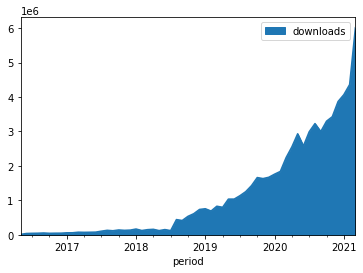

In [10]:
(df.pivot_table(values='downloads', index='period', aggfunc='sum')
 .plot.area());

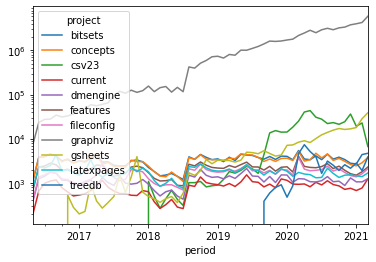

In [11]:
(df.pivot_table(values='downloads', index='period', columns='project',
                aggfunc='sum', fill_value=0)
 .plot(logy=True));

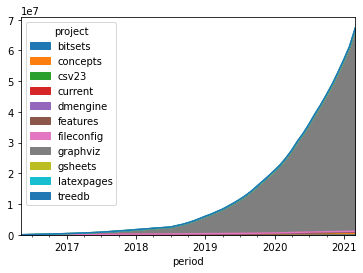

In [12]:
(df.pivot_table(values='downloads', index='period', columns='project',
                aggfunc='sum', fill_value=0)
 .cumsum().plot.area());

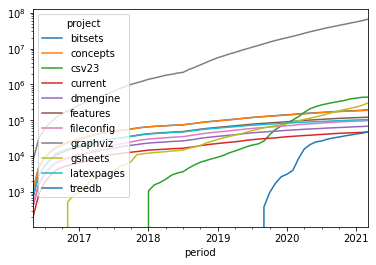

In [13]:
(df.pivot_table(values='downloads', index='period', columns='project',
                aggfunc='sum', fill_value=0)
 .cumsum().plot(logy=True));

In [14]:
(df.pivot_table(values='downloads', index='python', aggfunc='sum', margins=True)
 [lambda x: x['downloads'] > 1_000]
 .sort_values(by='downloads', ascending=False)
 .assign(ratio=lambda x: x / x.sum() * 2)
 .style.format({'downloads': '{:_d}', 'ratio': '{:.2%}'})
 .set_uuid('6')) 

,downloads,ratio
python,,
All,67_380_315,100.00%
3.7,24_694_044,36.65%
3.6,18_326_478,27.20%
2.7,14_106_604,20.94%
3.5,4_855_599,7.21%
3.8,2_866_347,4.25%
N/A,2_119_643,3.15%
3.9,222_771,0.33%
3.4,172_073,0.26%


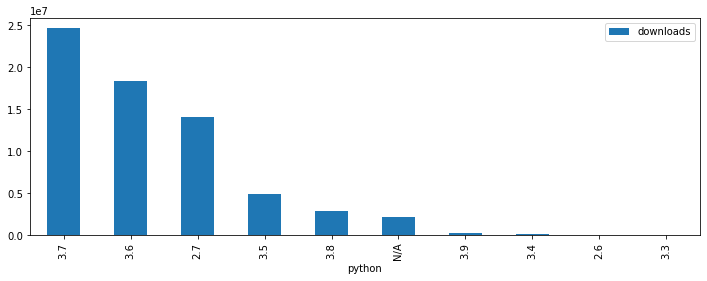

In [15]:
(df.pivot_table(values='downloads', index='python', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)[:10]
 .plot.bar(figsize=(12, 4)));

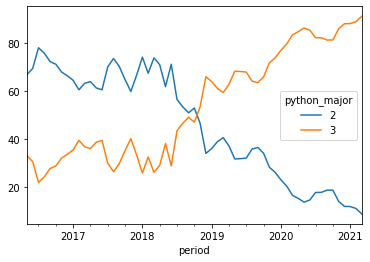

In [16]:
(df.pivot_table(values='downloads', index='period', columns='python_major',
                aggfunc='sum', fill_value=0)
 .stack(level='python_major')[lambda x: x > 1_000]
 .groupby('period').transform(lambda g: 100 * g / g.sum())
 .unstack(level='python_major', fill_value=0)
 .plot());

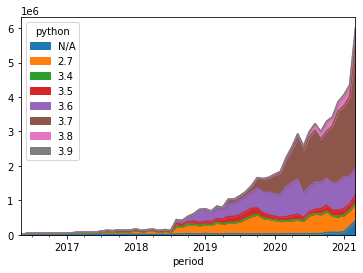

In [17]:
(df.pivot_table(values='downloads', index='period', columns='python',
                aggfunc='sum', fill_value=0)
 .stack(level='python')[lambda x: x > 1_000]
 .unstack(level='python', fill_value=0)
 .sort_values(axis='columns', by='python')
 .plot.area());

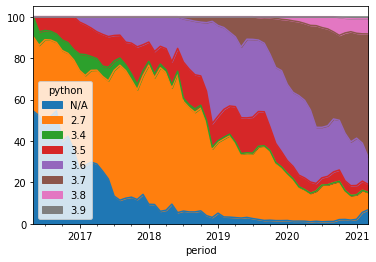

In [18]:
(df.pivot_table(values='downloads', index='period', columns='python',
                aggfunc='sum', fill_value=0)
 .stack(level='python')[lambda x: x > 1_000]
 .groupby('period').transform(lambda g: 100 * g / g.sum())
 .unstack(level='python', fill_value=0)
 .sort_values(axis='columns', by='python')
 .plot.area());

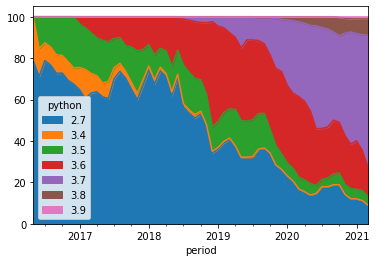

In [19]:
(df.pivot_table(values='downloads', index='period', columns='python',
                aggfunc='sum', fill_value=0)
 .drop('N/A', axis='columns')
 .stack(level='python')[lambda x: x > 1_000]
 .groupby('period').transform(lambda g: 100 * g / g.sum())
 .unstack(level='python', fill_value=0)
 .sort_values(axis='columns', by='python')
 .plot.area());

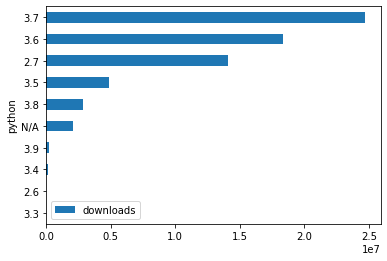

In [20]:
(df.pivot_table(values='downloads', index='python', aggfunc='sum')
 .sort_values(by='downloads')[-10:]
 .plot.barh());

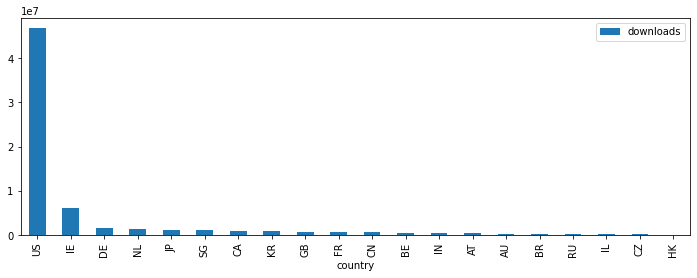

In [21]:
(df.pivot_table(values='downloads', index='country', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)[:20]
 .plot.bar(figsize=(12, 4)));

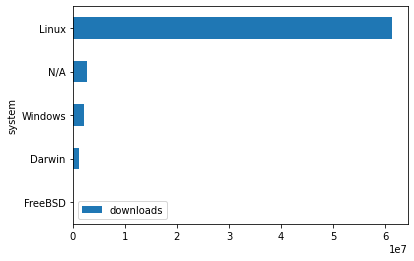

In [22]:
(df.pivot_table(values='downloads', index='system', aggfunc='sum')
 .sort_values(by='downloads')[-5:]
 .plot.barh());

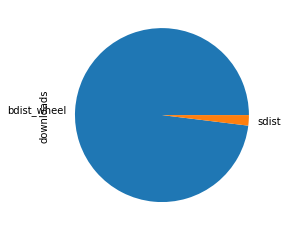

In [23]:
(df.pivot_table(values='downloads', index='type', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)
 ['downloads'].plot.pie());

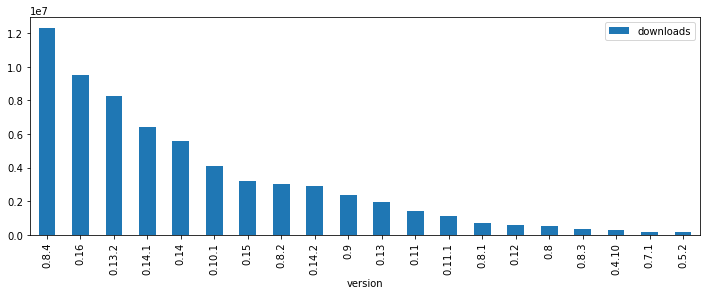

In [24]:
(df[df['project'] == 'graphviz']
 .pivot_table(values='downloads', index='version', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)[:20]
 .plot.bar(figsize=(12, 4)));